# Boosting
## AdaBoost(Adaptive Boosting)

In [43]:
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
df = sns.load_dataset("titanic")
# 欠損値を落とす
df.dropna(inplace=True)
# X, y を作成
X = df.loc[:, (df.columns!="survived") & (df.columns!="alive")]
y = df["survived"]
# カテゴリ変数をエンコーディングする(決定木をsklearnで扱うためにカテゴリ変数のエンコーディングが必要)
oe = OrdinalEncoder()
oe.set_output(transform="pandas")
X = oe.fit_transform(X)
# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [44]:
# Ada Boost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score

ada = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, random_state=0).fit(X_train, y_train)
y_pred_ada = ada.predict_proba(X_test)
print(f"adaboost AUC: {roc_auc_score(y_test, y_pred_ada[:, 1])}")

adaboost AUC: 0.9375


<BarContainer object of 13 artists>

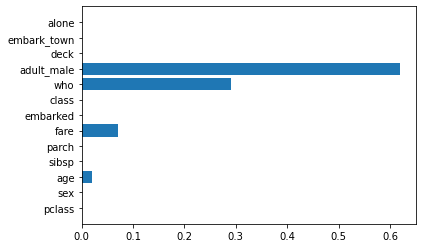

In [45]:
# モデルにおける各特徴量の重要度を以下のようにすると確認できる
import matplotlib.pyplot as plt
plt.barh(X.columns, ada.feature_importances_)

一回の分岐しかない決定木(max_depth=1)をデフォルトで利用されているので、どの決定木も同じような分岐をしてしまい、偏った特徴量の主にになっていることが予想される。  
ランダムフォレストの場合は、特徴量がランダムに選択されるので、色んな特徴量に重み付けされる。   
特徴量の重みづけの違いからも、AdaBoostとランダムフォレストのアルゴリズムの違いがわかる。

# gradient boosting 回帰
## スクラッチから実装

In [46]:
# 弱学習器(決定木)はsklearnのものを使う
from sklearn.tree import DecisionTreeRegressor

class MyGradientBoostingRegressor:
    
    def __init__(self, learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators = []
        
    def fit(self, X, y):
        self.F0 = y.mean();
        Fb = self.F0
        for _ in range(self.n_estimators):
            # 残差を計算
            r = y - Fb
            estimator = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            # 残差 r　を目的変数として学習するのが GBDT: Gradient Boosted Decision Tree の特徴
            estimator.fit(X, r)
            weight = estimator.predict(X)
            Fb += self.learning_rate * weight
            self.estimators.append(estimator)
    
    def predict(self, X):
        Fb = self.F0
        for estimator in self.estimators:
            Fb += self.learning_rate * estimator.predict(X)
        return Fb
        
            

<AxesSubplot:xlabel='horsepower', ylabel='mpg'>

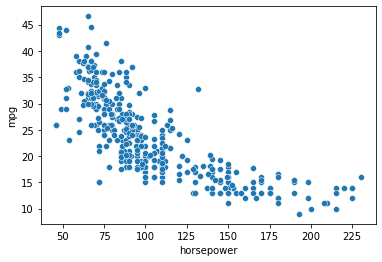

In [47]:
# MyGradientBoostingRegressorを使ってみる
import seaborn as sns
df = sns.load_dataset("mpg") # miles per gallon 車の燃費のデータ
df.dropna(inplace=True)
X = df["horsepower"].values.reshape(-1, 1)
y = df["mpg"].values
# データを描画したい場合
sns.scatterplot(x=df["horsepower"], y=df["mpg"])

In [48]:
lr = 0.03
my_gbr = MyGradientBoostingRegressor(learning_rate=lr, n_estimators=100, max_depth=1, random_state=0)
my_gbr.fit(X, y)
print(my_gbr.predict(X)[:10])


[17.95434839 15.74535562 15.74535562 15.74535562 16.96376992 15.74535562
 15.74535562 15.74535562 15.74535562 15.74535562]


## sklearnのGradientBoostingRegressorと比較する

In [49]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate=lr, n_estimators=100, max_depth=1, random_state=0).fit(X, y)
print(gbr.predict(X)[:10])
my_gbr.predict(X)[:10] == gbr.predict(X)[:10]

[17.95434839 15.74535562 15.74535562 15.74535562 16.96376992 15.74535562
 15.74535562 15.74535562 15.74535562 15.74535562]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

上の結果より、予測が完全に一致していることがわかる！！  
以下に、モデルの一つ目の弱分類器（決定木）の分岐を描画してみる

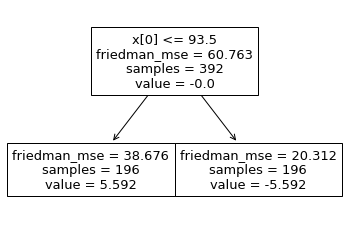

In [50]:
from sklearn.tree import plot_tree
model = gbr.estimators_[0][0]
_ = plot_tree(model)

#### 一つ目のデータの予測がどのように行われているのかを可視化する
`gbr.predict(X)[0]`は17.954348390521037であり、 `y[0]` の値である 18.0 にかなり近くなっている。  
この値がどのように予測されたかを可視化する

17.95434839052103

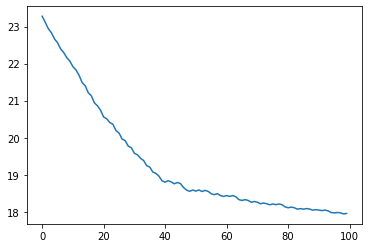

In [51]:
import numpy as np

results = []
idx = 0 # 最初のデータを追跡する
for t in gbr.estimators_:
    model = t[0]
    result = model.predict([X[idx]])
    results.append(result*lr)
    
F0 = np.mean(y)
Fb = F0 + np.cumsum(results)
plt.plot(Fb)
Fb[-1]

# gradient boosting 分類
## スクラッチから実装

In [63]:

class MyGradientBoostingClassifier:
    
    def __init__(self, learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators = []
    
    def fit(self, X, y):
        # F0は対数オッズ比
        self.F0 = np.log(y.mean()/(1-y.mean()))
        # 先にF0を同じ値を並べたベクトル化しておくとで、全ての変数をベクトルで扱えるようにする
        F0 = np.full(len(y), self.F0)
        Fb = F0
        for _ in range(self.n_estimators):
            # シグモイド関数にFbを代入することで確率を得る
            p = 1 / (1+np.exp(-Fb))
            r = y - p
            estimator = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            estimator.fit(X, r)
            X_leafs = estimator.apply(X)
            leaf_ids = np.unique(X_leafs)
            for leaf_id in leaf_ids:
                fltr = X_leafs == leaf_id
                # 弱学習器の出力の計算
                num = r[fltr].sum() # 分子は英語で numerator
                den = (p[fltr]*(1-p[fltr])).sum() # 分母は英語で denominatorという
                estimator_pred_proba = num / den
                # 弱学習器の出力を上書き
                estimator.tree_.value[leaf_id, 0, 0] = estimator_pred_proba
                # 当該データのFbを更新
                Fb[fltr] += self.learning_rate * estimator_pred_proba
            
            self.estimators.append(estimator)
                
    def predict_proba(self, X):
            Fb = np.full(X.shape[0], self.F0)
            
            for estimator in self.estimators:
                Fb += self.learning_rate * estimator.predict(X)
            return 1 / (1 + np.exp(-Fb))
            

In [64]:
# MyGradientBoostingClassifierをテストする
# データの準備
df = sns.load_dataset("titanic")
# 欠損値を落とす
df.dropna(inplace=True)
# X, y を作成
X = df.loc[:, (df.columns!="survived") & (df.columns!="alive")]
y = df["survived"]
# カテゴリ変数をエンコーディングする(決定木をsklearnで扱うためにカテゴリ変数のエンコーディングが必要)
oe = OrdinalEncoder()
oe.set_output(transform="pandas")
X = oe.fit_transform(X)
# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

my_gbc = MyGradientBoostingClassifier(learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0)
my_gbc.fit(X_train, y_train)
my_gbc.predict_proba(X_test)

array([0.5514342 , 0.4329777 , 0.80125347, 0.80125347, 0.5514342 ,
       0.25797762, 0.5514342 , 0.83715418, 0.88099514, 0.88099514,
       0.5514342 , 0.82137752, 0.82137752, 0.88099514, 0.5514342 ,
       0.5514342 , 0.5514342 , 0.82137752, 0.88099514, 0.40100637,
       0.88099514, 0.78760146, 0.88099514, 0.88099514, 0.80125347,
       0.5514342 , 0.40100637, 0.80125347, 0.4329777 , 0.4329777 ,
       0.4329777 , 0.88099514, 0.88099514, 0.88099514, 0.82137752,
       0.88099514, 0.82137752, 0.88099514, 0.40100637, 0.5514342 ,
       0.4329777 , 0.82137752, 0.5514342 , 0.78760146, 0.40100637,
       0.88099514, 0.88099514, 0.5514342 , 0.5514342 , 0.5514342 ,
       0.5514342 , 0.82137752, 0.5514342 , 0.88099514, 0.88099514])

## sklearnのGradientBoostingClassifierと比較する

In [68]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0)
gbc.fit(X_train, y_train)
print(gbc.predict_proba(X_test)[:, 1])
my_gbc.predict_proba(X_test)[:10] == gbc.predict_proba(X_test)[:, 1][:10]

[0.5514342  0.4329777  0.80125347 0.80125347 0.5514342  0.25797762
 0.5514342  0.83715418 0.88099514 0.88099514 0.5514342  0.82137752
 0.82137752 0.88099514 0.5514342  0.5514342  0.5514342  0.82137752
 0.88099514 0.40100637 0.88099514 0.78760146 0.88099514 0.88099514
 0.80125347 0.5514342  0.40100637 0.80125347 0.4329777  0.4329777
 0.4329777  0.88099514 0.88099514 0.88099514 0.82137752 0.88099514
 0.82137752 0.88099514 0.40100637 0.5514342  0.4329777  0.82137752
 0.5514342  0.78760146 0.40100637 0.88099514 0.88099514 0.5514342
 0.5514342  0.5514342  0.5514342  0.82137752 0.5514342  0.88099514
 0.88099514]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [69]:
# AUCの確認
print(f"gradient boosting AUC: {roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])}")

grad boost AUC: 0.9407051282051282


#### 一つ目のデータの予測がどのように行われているのかを可視化する
`gbc.predict_proba(X_test)[:, 1][0]`は0.5514342であり、この結果を導く

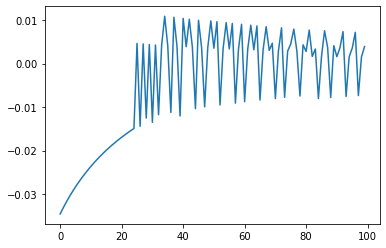

In [72]:
results = []
idx = 0 # 最初のデータを追跡する
for t in gbc.estimators_:
    model = t[0]
    result = model.predict([X_test.iloc[idx]])
    results.append(result * lr)

plt.plot(results)

In [75]:
F0 = np.log(y_train.mean()/(1 - y_train.mean()))
Fb = F0 + np.cumsum(results)[-1]
p = 1 / (1 + np.exp(-Fb))
p

0.551434197251246

`gbc.predict_proba(X_test)[:, 1][0]`の0.5514342と値が一致している！